# Continuous GFlowNets on a Simple 1D Line Environment

In [116]:
from matplotlib import pyplot as plt
from torch.distributions import Normal
import math
import numpy as np
import torch
import random
from tqdm import trange

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In this tutorial, we will explore a simple use-case of continuous GFlowNets: sampling from a multinomial Gaussian. This is an exceedingly simple example which is not representative of the complexities inherent with applying this method in real applications, but will highlight some common challenges and tricks useful. But first, please run the cell below to make available some helper functions:

In [117]:
def seed_all(seed):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)


def render(reward, trajectory=None):
    """Renders the reward distribution over the 1D env."""
    x = np.linspace(
        min(reward.mus) - reward.n_sd * max(reward.sigmas),
        max(reward.mus) + reward.n_sd * max(reward.sigmas),
        1000,
    )

    d = torch.exp(reward.log_reward(torch.tensor(x)))
    dual_plot = not isinstance(trajectory, type(None))

    if dual_plot:
        fig, axs = plt.subplots(2, 1)
        axs = axs.ravel()
    else:
        fig, axs = plt.subplots(1, 1)
        axs = [axs]  # Hack to allow indexing.

    if dual_plot:
        ax_dual = axs[0].twinx()  # Second axes for final state counts.
        ax_dual.hist(
            trajectory[:, -1, 0].cpu().numpy(),  # Final X Position.
            bins=100,
            density=False,
            alpha=0.5,
            color="red",
        )
        ax_dual.set_ylabel("Samples", color="red")
        ax_dual.tick_params(axis="y", labelcolor="red")

        n, trajectory_length, _ = trajectory.shape
        for i in range(n):
            axs[1].plot(
                trajectory[i, :, 0].cpu().numpy(),
                np.arange(1, trajectory_length + 1),
                alpha=0.1,
                linewidth=0.05,
                color='black',
            )
            axs[1].set_ylabel('Step')

    axs[0].plot(x, d, color="black")

    # Adds the modes.
    for mu in reward.mus:
        axs[0].axvline(mu, color="grey", linestyle="--")

    # S0
    axs[0].plot([reward.init_value], [0], 'ro')
    axs[0].text(reward.init_value + 0.1, 0.01, "$S_0$", rotation=45)

    # Means
    for i, mu in enumerate(reward.mus):
        idx = abs(x - mu.numpy()) == min(abs(x - mu.numpy()))
        axs[0].plot([x[idx]], [d[idx]], 'bo')
        axs[0].text(x[idx] + 0.1, d[idx], "Mode {}".format(i + 1), rotation=0)

    axs[0].spines[['right', 'top']].set_visible(False)
    axs[0].set_ylabel("Reward Value")
    axs[0].set_title("Line Environment")
    axs[0].set_ylim(0, max(d) * 1.1)

    if dual_plot:
        axs[1].set_xlim(axs[0].get_xlim())
        axs[1].set_xlabel("X Position")
    else:
        axs[0].set_xlabel("X Position")

    fig.tight_layout()
    plt.show()


# Hyperparameters

In [118]:
trajectory_length = 5
min_policy_std = 0.1
max_policy_std = 1.0
batch_size = 256
seed = 4444

Here, we are explore Continuous GFlowNets in an exceedingly simple case: from an initial starting point on the number line, sample a set of increments such that we learn to sample from some reward distribution. Here, that reward distribution will be some mixture of Gaussians. Each step will be sampled from Gaussians as well distribution.

The key difference with Continuous GFlowNets is that they sample some *delta* in a continuous space, instead of discrete actions. Typically, this means your GFlowNet uses a function approximator $f(\cdot)$, which accepts the current state $s_{t}$, to predict the *paramaters of a distribution* $\rho = \{p_1, p_2, ..., p_n\}$. Then your chosen distribution $D(\rho)$ is used to sample a real-valued tensor $s_{\Delta} \sim D(\rho)$ which is added to your current state to produce a the next step in the state space $s_{t+1} = s_{t} + s_{\Delta}$ (note, we no longer consider a DAG here, but rather a topological space with distinguished source and sink states).

As an aside, note that both $s_{\delta} and the distribution $D(\rho)$ can be as complex as you want, but this adds a lot of complexity and room for bugs. So to get you started, we're going to work with $s_{\delta}$ being a single scalar, and $D(\rho)$ being a simple Gaussian distribution. At the end, we will point to resources covering more complex settings which involve sampling from mixtures of distributions.

In our case, we want to increment along the number line in such a way that we learn to sample from some arbitrary multi-modal distribution. So we need a distribution from which to sample these steps. Recall the formula of a Gaussian:

$$g(x) = \frac{1}{\sigma\sqrt{2\pi}} exp \big(-\frac{1}{2} \frac{(x-\mu)^2}{\sigma^2} \big)$$
.

To parameterize this, we will need a neural network to predict the parameters of the Gaussian: $\mu$, the mean, and $\sigma$, the standard deviation. We're also going to enforce that $ 0.1 <= \sigma <= 2$ to help with convergence (see the hyperparameters above).

In our setup, we will define a multimodal Gaussian distribution on the 1D line. We will also define a an arbitrary starting point $S_0$ on the number line where all trajectories will start. The GFlowNet must sample increments along the number line such that it samples final values along the number line proportionally to the mixture distribution.

We need to ensure there are no cycles in our state space to follow the theory of GFlowNets, but in this set up, a cycle would be easy to obtain. If we sampled first an increment of $+1$ and then an increment of $-1$, we could produce a cycle, and there are an infinite number of these on the real number line. To do so, let's simply include the count value, $t$, in the state $s_t$. In this setup, the state vector is `[x_position, n_steps]`, and the previous trajectory $[0, 0] \rightarrow [1, 1] \rightarrow [0, 2]$ would not be considerd a cycle. This step counter also can be used to know when to terminate this process, otherwise we never sample a final value. In this case, let's always terminate when $t=5$ (see hyperparameters above). There are more sophisitcated ways to handle termination, but they add complexity, and we want to focus this tutorial on only the core concepts.

Since every state reachable by the backward policy must also be reachable by the forward policy, we also need to enforce that the the final transition of the backward policy goes exactly to $S_0$. We'll cover how this happens later.

# Defining the Environment

First let's define our environment. We require a few things. First, we need a reward distribution. This will be a mixture of Gaussians on the real number line, each defined by a $\mu$ and $\sigma$. The reward at each point will simply be the sum of the PDFs at that point across all elements of the mixture. We also define $S_0$ as `init_value`.

/tmp/ipykernel_3522/2321834419.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Normal(torch.tensor(m), torch.tensor(s)) for m, s in zip(mus, self.sigmas)


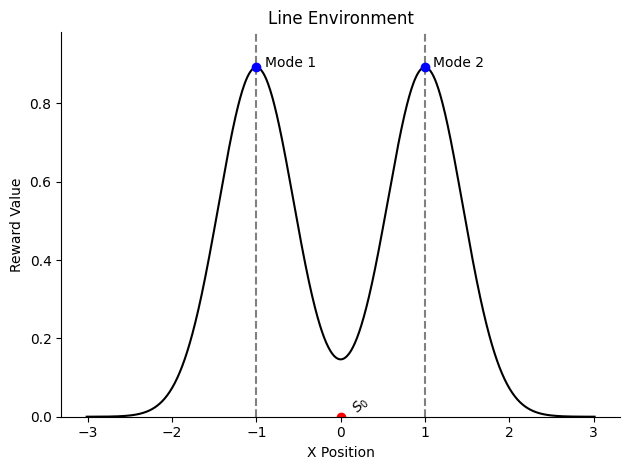

In [119]:
class LineEnvironment():
    def __init__(self, mus, variances, n_sd, init_value):
        self.mus = torch.tensor(mus)
        self.sigmas = torch.tensor([math.sqrt(v) for v in variances])
        self.variances = torch.tensor(variances)
        self.mixture = [
            Normal(torch.tensor(m), torch.tensor(s)) for m, s in zip(mus, self.sigmas)
        ]

        self.n_sd = n_sd
        self.lb = min(self.mus) - self.n_sd * max(self.sigmas)  # Convienience only.
        self.ub = max(self.mus) + self.n_sd * max(self.sigmas)  # Convienience only.

        self.init_value = init_value  # Used for s0.
        assert self.lb < self.init_value < self.ub

    def log_reward(self, x):
        """Sum of the exponential of each log probability in the mixture."""
        return torch.logsumexp(torch.stack([m.log_prob(x) for m in self.mixture], 0), 0)

    @property
    def log_partition(self) -> float:
        """Log Partition is the log of the number of gaussians."""
        return torch.tensor(len(self.mus)).log()


env = LineEnvironment(mus=[-1, 1], variances=[0.2, 0.2], n_sd=4.5, init_value=0)
render(env)

# Policies, Actions, and States

Recall that in order to act in our environment, we have to do two things. First, we need to use a function approximator to predict the parameters of a distribution, then to sample from that distribution to produce the actions. Here, we have a neural network that outputs $\mu$ and $\sigma$ of the normal distribution, with the constraint that `min_policy_std <=` $\sigma$ `<= max_policy_std`. Our policy is then this distribution object we can sample from:

In [120]:
def get_policy_dist(model, x):
    """
    A policy is a distribution we predict the parameters of using a neural network,
    which we then sample from.
    """
    pf_params = model(x)
    policy_mean = pf_params[:, 0]
    policy_std = torch.sigmoid(pf_params[:, 1]) * (max_policy_std - min_policy_std) + min_policy_std
    policy_dist = torch.distributions.Normal(policy_mean, policy_std)

    return policy_dist

To keep things simple, we'll enforce that all trajectories are exactly 5 steps. With probabilisitc exit actions, the logic becomes more tricky, though it is often useful in some applications. 

For each forward action, we will add the action value to the current state, and increment the step counter. A backward action is simply the inverse: we will substract the action value from the current state, and decrement the step counter.

Given this distribution we retrieve from `get_policy_dist()`, we sample an action $s_{\Delta} \sim D(\rho)$. Recall that our state representation is `(x_position, n_steps)`. In this case, we are sampling $x_{\Delta} \sim \mathcal{N}(\mu, \sigma^2)$, and our next state is `(x_position + x_delta, n_steps + 1)`.

We'll also define a function that initalizes a state at $S_0$, which in our case has the `x_position` set to whatever we defined in our environment, and `n_steps` to 0.

In [121]:
def step(x, action):
    """Takes a forward step in the environment."""
    new_x = torch.zeros_like(x)
    new_x[:, 0] = x[:, 0] + action  # Add action delta.
    new_x[:, 1] = x[:, 1] + 1  # Increment step counter.

    return new_x


def initalize_state(batch_size, device, env, randn=False):
    """Trajectory starts at state = (X_0, t=0)."""
    x = torch.zeros((batch_size, 2), device=device)
    x[:, 0] = env.init_value

    return x

# Training Loop

Below is a simple training loop. We're going to use Trajectory Balance (TB), so we need a forward model, backward model, and an estimate of logZ, along with an optimizer. So let's set those up first. We'll parameterize both the `forward_model` and the `backward_model` as two small neural networks, each taking in the state `[x_position, n_steps]` and outputting the parameters of a Normal distribution `[mean, standard_deviation]`. The `logZ` estimate is a scalar parameter. Note a common optimization trick for TB here, where the learning rate of `logZ` is faster than the other networks. 

These models will be used to predict the parameters of the policies themselves.

In [122]:
def setup_experiment(hid_dim=64, lr_model=1e-3, lr_logz=1e-1):

    forward_model = torch.nn.Sequential(torch.nn.Linear(2, hid_dim),
                                        torch.nn.ELU(),
                                        torch.nn.Linear(hid_dim, hid_dim),
                                        torch.nn.ELU(),
                                        torch.nn.Linear(hid_dim, 2)).to(device)

    backward_model = torch.nn.Sequential(torch.nn.Linear(2, hid_dim),
                                        torch.nn.ELU(),
                                        torch.nn.Linear(hid_dim, hid_dim),
                                        torch.nn.ELU(),
                                        torch.nn.Linear(hid_dim, 2)).to(device)

    logZ = torch.nn.Parameter(torch.tensor(0.0, device=device))

    optimizer = torch.optim.Adam(
        [
            {'params': forward_model.parameters(), 'lr': lr_model},
            {'params': backward_model.parameters(), 'lr': lr_model},
            {'params': [logZ], 'lr': lr_logz},
        ]
    )

    return (forward_model, backward_model, logZ, optimizer)

Finally, our training loop, which is greatly simplified due to the use of fixed-length trajectories. In our forward loop through the trajectory, we use our `forward_model` to calculate the `forward_policy`, sample an `action` from that policy, and finally calculate the log probability of that action an add it to `logPF`, which records the sum of the log probabilities (i.e., the product of the conditional probabilities, which is the probability of the trajectory). We store each new state in the trajectory.

For the backward loop, we sample the parameters of a `backward_policy` from the `backward_model`, and evaluate the log probability of the observed action (`trajectory[:, t, 0] - trajectory[:, t - 1, 0]`) under this policy. The trajectory dimensions are `[batch_dim, trajectory_step, state]`. We use this to calculate the probability of the backward trajectory by accumulating the sum of `logPB`. Note that the `n_step` counter is only part of the state, not the action, so we can remove it when indexing on the `state` dimension.

We finally calculate the `log_reward` from the terminal states under our environment reward, and calculate the trajectory balance loss, which we use to update the parameters of the `forward_model`, `backward_model`, and `logZ`.

This should only take a few minutes to train:

In [123]:
def train(seed, batch_size, trajectory_length, env, device, n_iterations=10_000):
    """Continuous GFlowNet training loop, with the Trajectory Balance objective."""
    seed_all(seed)
    forward_model, backward_model, logZ, optimizer = setup_experiment()  # Default hyperparameters used.
    losses = []
    tbar = trange(n_iterations)

    for it in tbar:
        optimizer.zero_grad()

        x = initalize_state(batch_size, device, env)

        # Trajectory stores all of the states in the forward loop.
        trajectory = torch.zeros((batch_size, trajectory_length + 1, 2), device=device)
        logPF = torch.zeros((batch_size,), device=device)
        logPB = torch.zeros((batch_size,), device=device)

        # Forward loop to generate full trajectory and compute logPF.
        for t in range(trajectory_length):
            policy_dist = get_policy_dist(forward_model, x)
            action = policy_dist.sample()
            logPF += policy_dist.log_prob(action)

            new_x = step(x, action)
            trajectory[:, t + 1, :] = new_x
            x = new_x

        # Backward loop to compute logPB from existing trajectory under the backward policy.
        for t in range(trajectory_length, 2, -1):
            policy_dist = get_policy_dist(backward_model, trajectory[:, t, :])
            action = trajectory[:, t, 0] - trajectory[:, t - 1, 0]
            logPB += policy_dist.log_prob(action)

        log_reward = env.log_reward(trajectory[:, -1, 0])  # Reward from the final state.

        # Compute Trajectory Balance Loss.
        loss = (logZ + logPF - logPB - log_reward).pow(2).mean()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if it % 100 == 0:
            tbar.set_description("Training iter {}: (loss={:.3f}, estimated logZ={:.3f}, LR={}".format(
                it,
                np.array(losses[-100:]).mean(),
                logZ.item(),
                optimizer.param_groups[0]['lr'],
                )
            )

    return (forward_model, backward_model, logZ)

forward_model, backward_model, logZ = train(seed, batch_size, trajectory_length, env, device)

Training iter 0: (loss=4.999, estimated logZ=0.100, LR=0.001:   0%|          | 6/10000 [00:00<02:54, 57.16it/s]

Training iter 9900: (loss=0.642, estimated logZ=1.985, LR=0.001: 100%|██████████| 10000/10000 [03:42<00:00, 44.96it/s]


Next, we can view the behaviour of our GFlowNet by sampling new trajectories under fixed models. We'll plot two things. On top, we'll see the distribution of the final samples from each trajectory, alongside the original reward distribution. Underneath it, we'll show the `x_position` values at each step along the full trajectory. Note that at inference time, we only need the `forward_model`.

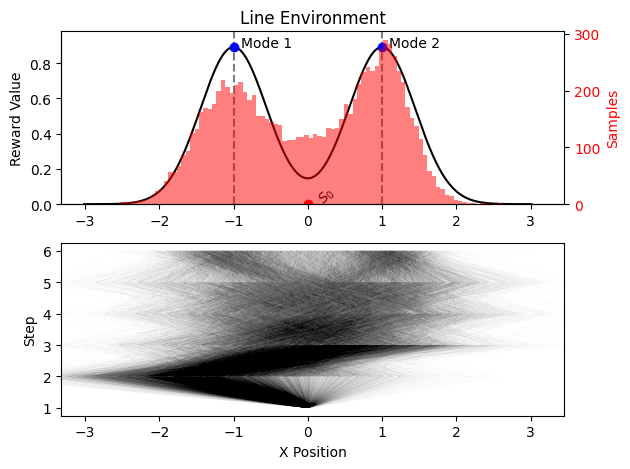

In [124]:
def inference(trajectory_length, forward_model, env, batch_size=10_000):
    """Sample some trajectories."""

    with torch.no_grad():
        trajectory = torch.zeros((batch_size, trajectory_length + 1, 2), device=device)
        trajectory[:, 0, 0] = env.init_value

        x = initalize_state(batch_size, device, env)

        for t in range(trajectory_length):
            policy_dist = get_policy_dist(forward_model, x)
            action = policy_dist.sample()

            new_x = step(x, action)
            trajectory[:, t + 1, :] = new_x
            x = new_x

    return trajectory

trajectories = inference(trajectory_length, forward_model, env)
render(env, trajectories)

# A Harder Example

Well, it looks OK! Maybe not perfect (we could get there training for long enough with good hyperparameters), but let's move on. In this example, there's a reasonable amount of probability mass connecting the two modes of the distribution. Let's try to make the example harder by placing the modes far from $S_0$:

/tmp/ipykernel_3522/2321834419.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Normal(torch.tensor(m), torch.tensor(s)) for m, s in zip(mus, self.sigmas)


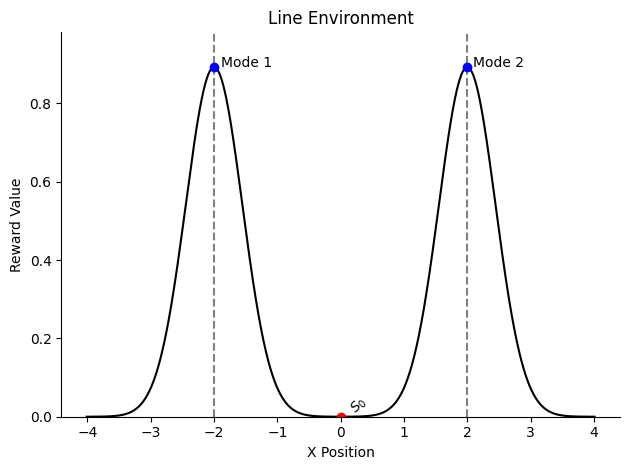

In [125]:
env = LineEnvironment(mus=[-2, 2], variances=[0.2, 0.2], n_sd=4.5, init_value=0)
render(env)

Let's train a model using the same hyperparameters on this environment.

Training iter 9900: (loss=0.508, estimated logZ=1.351, LR=0.001: 100%|██████████| 10000/10000 [04:22<00:00, 38.03it/s]


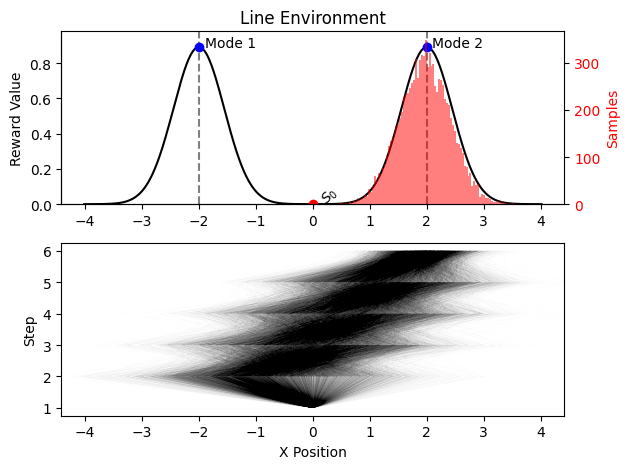

In [126]:
forward_model, backward_model, logZ = train(seed, batch_size, trajectory_length, env, device)
trajectories = inference(trajectory_length, forward_model, env)
render(env, trajectories)

What we're seeing here is mode collapse due to on policy training. We can fix this with off policy exploration.

We can go off policy in many ways, but one simple way would be to add some constant to the variance predicted by our forward policy for the normal distribution. We can also decay this constant linearly over training iterations too facilitate convergence.

Let's define a new function that retrieves both our learned policy and off policy sampler:

In [127]:
def get_policy_and_exploration_dist(model, x, off_policy_noise):
    """
    A policy is a distribution we predict the parameters of using a neural network,
    which we then sample from.
    """
    pf_params = model(x)
    policy_mean = pf_params[:, 0]
    policy_std = torch.sigmoid(pf_params[:, 1]) * (max_policy_std - min_policy_std) + min_policy_std
    policy_dist = torch.distributions.Normal(policy_mean, policy_std)

    # Add some off-policy exploration - TODO: FIll in the Blank here!
    exploration_dist = torch.distributions.Normal(policy_mean, policy_std + off_policy_noise)

    return policy_dist, exploration_dist


In the below training loop, let's add the changes needed to allow for off policy exploration. To do so, we need to accomplish a few things:

1) Define a value to increase the variance by, to encourage exploration. Ideally, this would be on a schedule, i.e,, the value we are adding to the variance of the predicted distribution will decrease over iterations. Let's use the `init_explortation_noise` variable for this.
2) Sample actions from the exploration distribution.
3) Calculate `logPF` using the log probabilities from the policy distribution.

In [128]:
def train_with_exploration(
        seed,
        batch_size,
        trajectory_length,
        env,
        device,
        init_explortation_noise,
        n_iterations=10_000
    ):
    """Continuous GFlowNet training loop, with expploration, and the Trajectory Balance objective."""
    seed_all(seed)
    forward_model, backward_model, logZ, optimizer = setup_experiment()   # Default hyperparameters used.
    losses = []
    tbar = trange(n_iterations)

    # TODO: Fill in the blank, optional.
    exploration_schedule = np.linspace(init_explortation_noise, 0,  n_iterations)

    for iteration in tbar:
        optimizer.zero_grad()

        x = initalize_state(batch_size, device, env)

        # Trajectory stores all of the states in the forward loop.
        trajectory = torch.zeros((batch_size, trajectory_length + 1, 2), device=device)
        logPF = torch.zeros((batch_size,), device=device)
        logPB = torch.zeros((batch_size,), device=device)

        # Forward loop to generate full trajectory and compute logPF.
        for t in range(trajectory_length):
            # TODO: Fill in the blanks here.
            policy_dist, exploration_dist = get_policy_and_exploration_dist(
                forward_model,
                x,
                exploration_schedule[iteration],
            )
            action = exploration_dist.sample()
            logPF += policy_dist.log_prob(action)

            new_x = step(x, action)
            trajectory[:, t + 1, :] = new_x
            x = new_x

        # Backward loop to compute logPB from existing trajectory under the backward policy.
        for t in range(trajectory_length, 2, -1):
            policy_dist = get_policy_dist(backward_model, trajectory[:, t, :])
            action = trajectory[:, t, 0] - trajectory[:, t - 1, 0]
            logPB += policy_dist.log_prob(action)

        log_reward = env.log_reward(trajectory[:, -1, 0])  # Reward from the final state.

        # Compute Trajectory Balance Loss.
        loss = (logZ + logPF - logPB - log_reward).pow(2).mean()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if iteration % 100 == 0:
            tbar.set_description("Training iter {}: (loss={:.3f}, estimated logZ={:.3f}, LR={}, off policy noise={:.4f})".format(
                iteration,
                np.array(losses[-100:]).mean(),
                logZ.item(),
                optimizer.param_groups[0]['lr'],
                exploration_schedule[iteration],  # TODO: Remove (b/c of fill in the blanks)?
                )
            )

    return (forward_model, backward_model, logZ)


Note there are 3 elements defining the difficulty of learning this task: the `init_exploration_noise`, `trajectory_length`, and `n_iterations` hyperparameters. Increasing the noise without increasing the trajectory length, or vice versa, will not produce a good solution. Here we've provided the magic hyperparameters, but feel free to play around to see how easy it is to produce a bad sampler.

In [129]:
init_exploration_noise = 2
trajectory_length = 10
n_iterations = 10_000

forward_model, backward_model, logZ = train_with_exploration(
    seed,
    batch_size,
    trajectory_length,
    env,
    device,
    init_exploration_noise,
    n_iterations=n_iterations,
)

Training iter 9900: (loss=1.176, estimated logZ=1.986, LR=0.001, off policy noise=0.0198): 100%|██████████| 10000/10000 [06:37<00:00, 25.18it/s] 


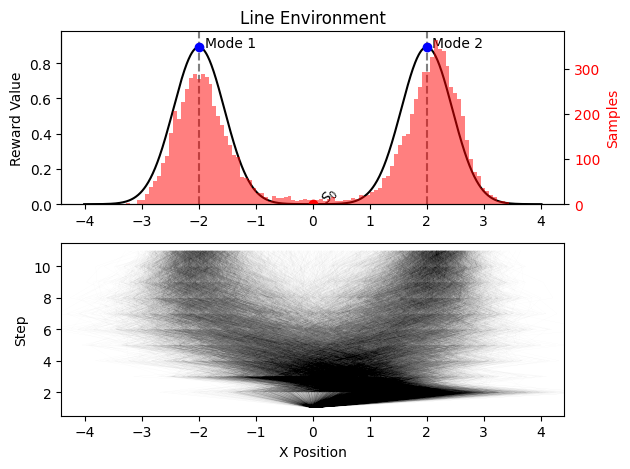

In [130]:
trajectories = inference(trajectory_length, forward_model, env)
render(env, trajectories)

# A Too Hard Example?

Looks good! Let's try something more complex...

/tmp/ipykernel_3522/2321834419.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Normal(torch.tensor(m), torch.tensor(s)) for m, s in zip(mus, self.sigmas)


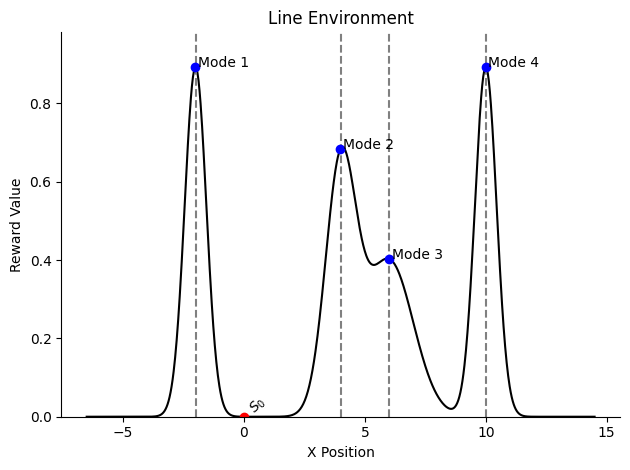

In [131]:
env = LineEnvironment(
    mus=[-2, 4, 6, 10],
    variances=[0.2, 0.4, 1, 0.2],
    n_sd=4.5,
    init_value=0
)
render(env)

Here, we have multiple challenges. Our starting point $S_0$ is now closer to Mode 1 than Modes 2 & 3, but the those combined modes have twice the probability mass that Mode 1 has. Furthermore, there is Mode 4, quite far from the initial starting point. To get started, let's modify some of out hyperparamaters to enable better sampling and exploration of this environment, and train for 10k iterations. We'll do this by allowing the policy to sample from Gaussian distributions with larger $\sigma$ values, and increasing the `init_exploration_noise` value.

In [132]:
init_exploration_noise = 5
trajectory_length = 10
n_iterations = 10_000
min_policy_std = 0.1
max_policy_std = 5.0

forward_model, backward_model, logZ = train_with_exploration(
    seed,
    batch_size,
    trajectory_length,
    env,
    device,
    init_exploration_noise,
    n_iterations=n_iterations,
)

Training iter 9900: (loss=3.436, estimated logZ=3.427, LR=0.001, off policy noise=0.0495): 100%|██████████| 10000/10000 [07:25<00:00, 22.46it/s]  


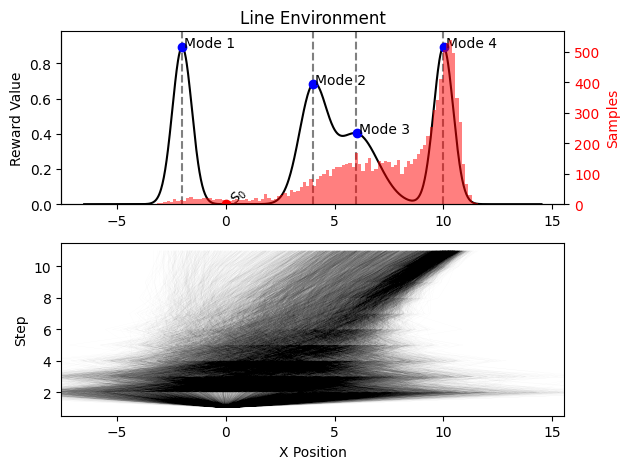

In [133]:
trajectories = inference(trajectory_length, forward_model, env)
render(env, trajectories)

Things aren't looking good yet. The model has learned to sample positive x positions due to majority of the reward mass being located in this region, but we are nowhere close to sampling from the correct probability distribution.

We likely don't have time to train this during the tutorial, but by playing with the above hyperparameters long enough, we can eventually learn to sample from this reward distribution. Try playing with this notebook at home to build an intution as to how the different hyperparameters affect the results:

+ `trajectory_length`
+ `init_exploration_noise`
+ `min/max_policy_std`
+ `n_iterations`
+ `learning_rate` (for the model and logZ estimate seperately!)
+ `hid_dim`

A key takeaway here is that the complexity of tuning the hyperparameters for training a continuous GFlowNet quickly grows with the complexity of the environment... even in a very simple case such as this one. 